# Creating a Convolutional Neural Network to Classify Doodles

Import OS

In [1]:
import os
import uuid
import shutil
import json
import copy
from datetime import datetime

Import Data Processing and Visualisation

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time
import random

Import Deep Learning

In [3]:
import torch
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

Prepare Functions

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cpu


## Split the data

In [5]:
train_dir = './working/train/'
val_dir = './working/validation/'
dataset_path = './dataset/doodle/'

In [6]:
files_to_keep = 300
train_ratio = 0.9

for root, dirs, files in (os.walk(dataset_path)):
    split_index = int(len(files) * train_ratio)
    category = os.path.basename(root)
    train_category_dir = os.path.join(train_dir, category)
    val_category_dir = os.path.join(val_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(val_category_dir, exist_ok=True)
    for i, file in enumerate(files):
        source = os.path.join(root, file)
        if i < split_index:
            destination = os.path.join(train_category_dir, file)
        else:
            destination = os.path.join(val_category_dir, file)
        shutil.move(source, destination)


## Load the Data

In [7]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(64, padding=4),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

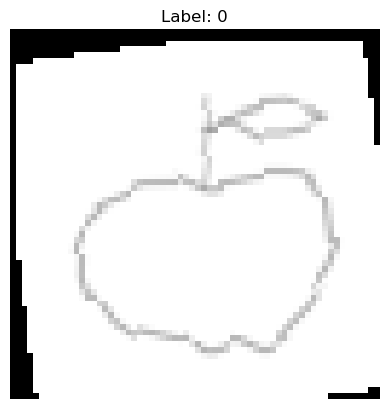

In [8]:
val_iter = iter(val_loader)
images, labels = next(val_iter,)

first_image = images[9]

first_image_np = transforms.functional.to_pil_image(first_image)


plt.imshow(first_image_np, cmap="gray")
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')  # Hide axis labels
plt.show()

### Hyperparameters

In [9]:
n_epochs=10
batch_size=64

lr=0.001
momentum=0.9
lr_scheduler=True
base_lr=0.001
max_lr=0.01

## Load and Train resnet18

In [10]:
model = models.resnet18(pretrained=True)

C:\Users\Basem\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Basem\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 23)

In [12]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)

In [14]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
correct = 0
accuracy_best = 0
best_model_wts = copy.deepcopy(model.state_dict())

# Training loop
for epoch in tqdm(range(n_epochs)):
    model.train()  # Set the model to training mode
    print(datetime.now())
    running_loss=0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()  
        z = model(x)           

        loss = criterion(z, y)  
        loss.backward()         
        optimizer.step()    
        
        running_loss+= loss.item()
        

    print(f"Epoch {epoch + 1} done")

    scheduler.step()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for x_test, y_test in val_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)

            z = model(x_test)  # Forward pass
            _, yhat = torch.max(z.data, 1)  
            total += labels.size(0)
            correct += (yhat == y_test).sum().item() 

    accuracy = correct / total
    if accuracy > accuracy_best:
        accuracy_best = accuracy
        best_model_wts = copy.deepcopy(model.state_dict())

    print('Learning rate:', optimizer.param_groups[0]['lr'])
    print(f"The validation accuracy for epoch {epoch + 1}: {accuracy:.4f}")

# Load the best model weights
model.load_state_dict(best_model_wts)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

2024-08-16 09:47:09.463161
Epoch 1 done


 10%|████████                                                                        | 1/10 [13:43<2:03:34, 823.88s/it]

Learning rate: 0.001
The validation accuracy for epoch 1: 0.7504
2024-08-16 10:00:53.349681
Epoch 2 done


 20%|████████████████                                                                | 2/10 [26:09<1:43:40, 777.58s/it]

Learning rate: 0.001
The validation accuracy for epoch 2: 0.8154
2024-08-16 10:13:18.513904
Epoch 3 done


 30%|████████████████████████                                                        | 3/10 [38:20<1:28:16, 756.67s/it]

Learning rate: 0.001
The validation accuracy for epoch 3: 0.8377
2024-08-16 10:25:30.312497
Epoch 4 done


 40%|████████████████████████████████                                                | 4/10 [51:10<1:16:10, 761.69s/it]

Learning rate: 0.001
The validation accuracy for epoch 4: 0.8543
2024-08-16 10:38:19.701520
Epoch 5 done


 50%|███████████████████████████████████████                                       | 5/10 [1:03:04<1:02:03, 744.70s/it]

Learning rate: 0.001
The validation accuracy for epoch 5: 0.8662
2024-08-16 10:50:14.277513
Epoch 6 done


 60%|████████████████████████████████████████████████                                | 6/10 [1:15:43<49:58, 749.53s/it]

Learning rate: 0.001
The validation accuracy for epoch 6: 0.8708
2024-08-16 11:02:53.170811
Epoch 7 done


 70%|████████████████████████████████████████████████████████                        | 7/10 [1:28:07<37:23, 747.75s/it]

Learning rate: 0.0001
The validation accuracy for epoch 7: 0.8783
2024-08-16 11:15:17.273216
Epoch 8 done


 80%|████████████████████████████████████████████████████████████████                | 8/10 [1:40:22<24:47, 743.63s/it]

Learning rate: 0.0001
The validation accuracy for epoch 8: 0.8766
2024-08-16 11:27:32.073866
Epoch 9 done


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:52:05<12:10, 730.86s/it]

Learning rate: 0.0001
The validation accuracy for epoch 9: 0.8783
2024-08-16 11:39:14.838150
Epoch 10 done


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [2:04:37<00:00, 747.79s/it]

Learning rate: 0.0001
The validation accuracy for epoch 10: 0.8815


<All keys matched successfully>

In [20]:
torch.save(model, 'model_23c_3000n_10e.pt')